# Running Matlab in Jupyter

Every now and then I have to use some Matlab functions in a project. For this reason I still have my Matlab version 2012b around, from a time when I was working much more in Matlab and I still had a license therefore (the one good thing of Matlab: a once bought license is forever, you just cannot update). What I would like to do is running this particular Matlab code in Jupyter, doing my usual Python stuff before and after calling that function.

There are a couple of packages out there to help using Matlab in Jupyter. There are even entire Matlab kernels, so you can use Matlab in your dedicated Jupyter notebook. Some repositories:

- https://github.com/imatlab/imatlab;
- https://github.com/Calysto/matlab_kernel;
- https://github.com/arokem/python-matlab-bridge.

Using the second package from this list, `matlab_kernel`, there was even a Matlab class created entirely in Jupyter Notebooks, available on ReadTheDocs and on Github, something we are familiar from Python: Harvard AM111 2017 Fall; *Introduction to Scientific Computing*, https://am111.readthedocs.io.

**However, most of them are overshoot for my purposes, or require MATLAB 2016b or newer with the new [MATLAB API for Python](https://www.mathworks.com/help/matlab/matlab-engine-for-python.html).**

This notebook shows two (of probably many) ways of running Matlab code in a Notebook without too much fiddling. The first one is simple, using the `%%bash`-magic of the notebook. Downside of the simple approach is that there is no realtime output of the Matlab shell. The second option uses `subprocess`, with which we can monitor the output from Matlab. And at the end an example to pass Python variables to Matlab and the result from Matlab back to Python.

For this code to work you must have Matlab installed, and `matlab` must be in your bash-PATH, if not you have to replace the `matlab`-commands with the full path to your binary. They work on my Linux machine, and I assume it is the same on a Mac. It might work on Windows as well, but I don't know.

In [1]:
import subprocess
import numpy as np
from scipy import io as sio
import matplotlib.pyplot as plt

# Create script-string for Matlab

We basically just write the whole script in one string, on one line. In order to make it visually more attractive we split it over several lines, ending each line with `\` to continue the line. This is rather fragile, and you really have to end each command with a `;` as the command is all in one line, otherwise it will fail. So it is only convenient for small scripts. (There might be better ways of which I am not aware of.)

The example script doesn't make a lot of sense, and is just for demonstration purposes. I specifically entered the `pause(3)`-commands, so we can check if the output in the notebook is real-time or not.

In [2]:
script = """\
    x = 1:.5:pi; \
    disp(['x = ', num2str(x)]); \
    pause(3); \
    ; \
    y = sin(x); \
    disp(['y = sin(x) = ', num2str(y)]); \
    pause(3); \
    ; \
    disp('Finished demo in Matlab'); \
    quit; \
"""

## Method 1: `%%bash-magic`

This method is straight forward, **but you'll have to wait till the end to see the output**.

The `-nojvm` tells Matlab to start without Java, which implies that no GUI is started an the splash-screen is also suppressed. You can provide as many arguments as you want with "" in the first line, they are numbered sequentially.

In [3]:
%%bash -s "$script"
matlab -nojvm -r "$1"


                            < M A T L A B (R) >
                  Copyright 1984-2012 The MathWorks, Inc.
                    R2012b (8.0.0.783) 64-bit (glnxa64)
                              August 22, 2012

 
To get started, type one of these: helpwin, helpdesk, or demo.
For product information, visit www.mathworks.com.
 
x = 1         1.5           2         2.5           3
y = sin(x) = 0.84147     0.99749      0.9093     0.59847     0.14112
Finished demo in Matlab


## Method 2: Using `subprocess`

By using `subprocess` and writing a small while-loop we gain real-time output from Matlab.

At the same time we can suppress the initial few lines (`< M A T L A B (R) > ...`), as we don't want to see them every time.

In [4]:
def matlab(command, startup_info=False):
    """Run a command in Matlab, flushing stdout continuously.
    
    startup_info: bool
        If True, it will print the initial Matlab copyright etc.
    """
    
    # We add `disp('outputstarting')` at the beginning, so we can check for
    # it and suppress the MATLAB-startup message.
    if not startup_info:
        command = "disp('outputstarting'); "+command
    
    # Start the process
    process = subprocess.Popen(['matlab', '-nojvm', '-r', command],
                               stdout=subprocess.PIPE, stderr=subprocess.PIPE)

    # Monitor STDOUT and STDERR
    while True:
        line = process.stdout.readline()  # Get line

        # If line is empty, Matlab finished, exit loop
        if not line:
            break
            
        # Print line depeding on startup_info
        lline = line.rstrip().decode('latin')
        if startup_info:
            print(lline)
        elif 'outputstarting' in lline:
            startup_info = True

Now we can simply call `matlab(script)` to run our desired script in Matlab:

In [5]:
matlab(script)

x = 1         1.5           2         2.5           3
y = sin(x) = 0.84147     0.99749      0.9093     0.59847     0.14112
Finished demo in Matlab


## Passing arguments

The reason why I want to run Matlab in the notebook is because I do some calculations before and after calling the particular Matlab script, so passing variables is crucial. Thanks to `scipy.io` this is rather easy. To make it easier we also write a little function:

In [6]:
def save4mat(variables, fname):
    """Store variables in a dict; save dict as `fname.mat` in current directory.
    
    variables : list of strings
    fname : string
    """
    pvars = {}
    for name in variables:
        pvars[name] = eval(name)
    
    sio.savemat(fname, pvars)

Do some calculation in Python, and store it in `pythonvars.mat`.

In [7]:
x = np.linspace(0, 3*np.pi, 1001)
mult = np.linspace(0, 1, x.size)

save4mat(['x', 'mult'], 'pythonvars')

Call Matlab; load `pythonvars.mat`; do some calculation; store in `output.mat`.

In [8]:
matlab("""\
    load pythonvars; \
    y = sin(x.*mult); \
    save('output', 'y'); \
    disp('Finished calculation in Matlab'); \
    quit; \
""")

Finished calculation in Matlab


Load `output.mat` in Python, get `y`.

In [9]:
y = sio.loadmat('output')['y'][0]

A small figure to check if this did what we wanted...

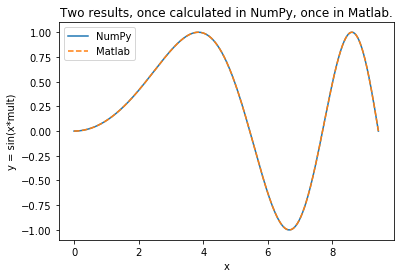

In [10]:
plt.figure()
plt.title('Two results, once calculated in NumPy, once in Matlab.')
plt.plot(x, np.sin(x*mult), label='NumPy')
plt.plot(x, y, '--', label='Matlab')
plt.xlabel('x')
plt.ylabel('y = sin(x*mult)')
plt.legend()
plt.show()

That's it, very lightweight. We only need the packages `subprocess` and `scipy.io`, and defined two small functions, `matlab` and `save4mat`. With this we can happily continue to code in our Python notebooks, but call that one bloody function or script that we have to use in Matlab.